In [ ]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# Extract Spark
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# Install findspark
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TfL Cycle Hire Analysis") \
    .master("local[2]") \
    .getOrCreate()

# Verify the Spark session is running
spark


In [ ]:
# Download the dataset
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip -O cyclehireusagestats-2014.zip

# Extract the dataset
!unzip -o cyclehireusagestats-2014.zip -d cyclehireusagestats-2014



--2024-05-19 12:10:26--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.97.104, 104.16.98.104
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.97.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   131MB/s    in 1.6s    

2024-05-19 12:10:28 (131 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: cyclehireusagestats-2014/1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: cyclehireusagestats-2014/10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: cyclehireusagestats-2014/10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: cyclehireusagestats-2014/11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: cyclehireusa

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql.functions import col, avg

# Path to the extracted CSV files
data_path = "cyclehireusagestats-2014/*.csv"
# Load all CSV files into a single DataFrame
j_df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show the schema to ensure data is loaded correctly
j_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:
# Check column names and data types
j_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



The Features are currently not in the appropriate datatypes. let us assign the correct datatype to each feature.


In [ ]:
from pyspark.sql.functions import col, to_timestamp

# Convert 'Rental Id' to integer
j_df = j_df.withColumn("Rental Id", col("Rental Id").cast("int"))

# Convert 'Duration' to integer
j_df = j_df.withColumn("Duration", col("Duration").cast("int"))

# Convert 'Bike Id' to integer
j_df = j_df.withColumn("Bike Id", col("Bike Id").cast("int"))

# Convert 'EndStation Id' to integer
j_df = j_df.withColumn("EndStation Id", col("EndStation Id").cast("int"))

# Convert 'StartStation Id' to integer
j_df = j_df.withColumn("StartStation Id", col("StartStation Id").cast("int"))

# Convert 'End Date' and 'Start Date' to timestamp
j_df = j_df.withColumn("End Date", to_timestamp(col("End Date"), "dd/MM/yyyy HH:mm"))
j_df = j_df.withColumn("Start Date", to_timestamp(col("Start Date"), "dd/MM/yyyy HH:mm"))

# Verify the schema
j_df.printSchema()


root
 |-- Rental Id: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: integer (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- EndStation Id: integer (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- StartStation Id: integer (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [ ]:
numRows = j_df.count()
numRows

11481596

In [ ]:
from pyspark.sql.functions import countDistinct

# Count the total number of unique stations
total_stations_count = j_df.select(countDistinct("StartStation Id")).collect()[0][0]

# Show the total number of stations
print("Total number of stations:", total_stations_count)


Total number of stations: 756


we have a total of 755 start stations in the dataset

In [ ]:
from pyspark.sql.functions import countDistinct

# Count the total number of unique stations
total_endstations_count = j_df.select(countDistinct("EndStation Id")).collect()[0][0]

# Show the total number of stations
print("Total number of stations:", total_endstations_count)

Total number of stations: 758


we have a total of 755 end stations in the dataset

In [ ]:
# Summary statistics for numerical columns
j_df.describe().show()

+-------+--------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|           Rental Id|          Duration|           Bike Id|     EndStation Id|     EndStation Name|   StartStation Id|   StartStation Name|       StartMonth|
+-------+--------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            10209849|          10209849|          10209849|          10209849|            10209849|          10209849|            10209849|         10209849|
|   mean|3.4862682533870876E7|1470.5896100911973| 6713.614915754386|320.42489149447755|                null| 321.0774570711085|                null|6.923114631763898|
| stddev|   3168841.953882178|12958.309902541674|3720.0327495908728| 210.2202608856122|                null|210.77305355164626|                null|3.156147585725756

Looks like we have some nulls rows in the dataset. we will be dealing with this

In [ ]:
# Filter out rows where all columns are null
null_rows = j_df.filter((col("Start Date").isNull()) & \
                        (col("End Date").isNull()) & \
                        (col("StartStation Id").isNull()) & \
                        (col("StartStation Name").isNull()) & \
                        (col("EndStation Id").isNull()) & \
                        (col("EndStation Name").isNull()) & \
                        (col("Bike Id").isNull()) & \
                        (col("Duration").isNull()) & \
                        (col("Rental Id").isNull()))

# Show the null rows
null_rows.show(truncate=False)


+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|null     |null    |null   |null    |null         |null           |null      |null           |null             |
|null     |null    |null   |null    |null         |null           |null      |null           |null             |
|null     |null    |null   |null    |null         |null           |null      |null           |null             |
|null     |null    |null   |null    |null         |null           |null      |null           |null             |
|null     |null    |null   |null    |null         |null           |null      |null           |null             |
|null     |null    |null   |null    |null         |null           |null      |null           |nu

In [ ]:
# Let us drop rows where all columns are null
j_df = j_df.na.drop()

# Show the resulting DataFrame
j_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:
j_df.agg({"Duration": "min"}).show()
j_df.agg({"Duration": "mean"}).show()
j_df.agg({"Duration": "max"}).show()
j_df.agg({"Duration": "skewness"}).show()

+-------------+
|min(Duration)|
+-------------+
|        -1020|
+-------------+

+------------------+
|     avg(Duration)|
+------------------+
|1465.8953047010398|
+------------------+

+-------------+
|max(Duration)|
+-------------+
|        99900|
+-------------+

+------------------+
|skewness(Duration)|
+------------------+
|  83.1208722223165|
+------------------+



We have a negative figure for Duration. This might be a computation error as we can not have a negative duration for rides. we will be dropping these rows


In [ ]:
# Checking for any negative duration and then drop them afterwards.
j_df_neg = j_df.filter(col("Duration") < 0)
j_df_neg.show(truncate = False)

+---------+--------+-------+----------------+-------------+----------------------------------------+----------------+---------------+--------------------------------+
|Rental Id|Duration|Bike Id|End Date        |EndStation Id|EndStation Name                         |Start Date      |StartStation Id|StartStation Name               |
+---------+--------+-------+----------------+-------------+----------------------------------------+----------------+---------------+--------------------------------+
|38748858 |-2340   |11733  |26/10/2014 01:01|489          |Christian Street, Whitechapel           |26/10/2014 01:40|64             |William IV Street, Strand       |
|38748947 |-2820   |10942  |26/10/2014 01:05|291          |Claverton Street, Pimlico               |26/10/2014 01:52|755            |The Vale, Chelsea               |
|38748893 |-2160   |9949   |26/10/2014 01:08|470          |Mostyn Grove, Bow                       |26/10/2014 01:44|17             |Hatton Wall, Holborn            

In [ ]:
# Now let us drop all negative duration rides as this is not possible.

j_df = j_df.filter(col("Duration")>0)

In [ ]:
# Group by StartStation Name and StartStation Id, then calculate the average duration
avg_duration_per_station = j_df.groupBy("StartStation Name", "StartStation Id").agg(avg("Duration").alias("Average_Duration"))

In [ ]:
# Sort by Average_Duration in descending order and select the top 10
top_10_stations = avg_duration_per_station.orderBy(col("Average_Duration").desc()).limit(10)

In [ ]:
# Show the results
top_10_stations.show(truncate=False)

+-------------------------------------------+---------------+------------------+
|StartStation Name                          |StartStation Id|Average_Duration  |
+-------------------------------------------+---------------+------------------+
|Mechanical Workshop Penton                 |346            |15120.0           |
|South Quay East, Canary Wharf              |494            |4847.771428571428 |
|Putney Bridge Road, East Putney            |728            |3549.8193583176057|
|Ravenscourt Park Station, Hammersmith      |668            |3518.418685121107 |
|Speakers' Corner 2, Hyde Park              |406            |3398.7301846040996|
|Bromley High Street, Bromley               |484            |3288.403015764222 |
|Westfield Library Corner, Shepherd's Bush  |591            |3276.5668559628293|
|Putney Rail Station, Putney                |694            |3142.0678952473327|
|Shepherd's Bush Road North, Shepherd's Bush|667            |3090.603015075377 |
|Cadogan Close, Victoria Par

In [ ]:
!pip install matplotlib seaborn

In [ ]:
top_10_stations_df = top_10_stations.toPandas()


<ipython-input-138-44ac3d5b1ddc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_stations_df, x="Average_Duration", y="StartStation Name", palette="viridis")


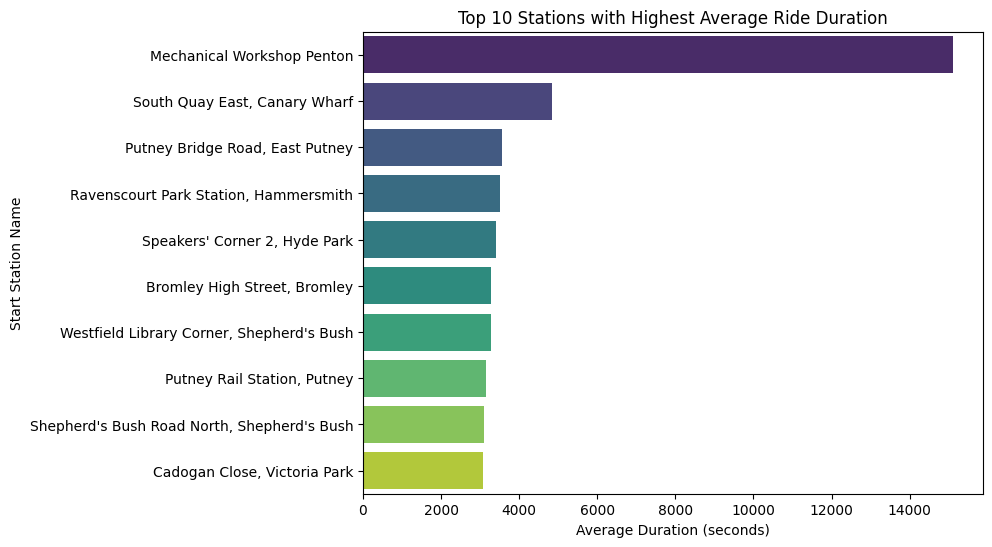

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=top_10_stations_df, x="Average_Duration", y="StartStation Name", palette="viridis")
plt.xlabel("Average Duration (seconds)")
plt.ylabel("Start Station Name")
plt.title("Top 10 Stations with Highest Average Ride Duration")
plt.show()


In [ ]:
# let us check for the bottom 10

# Sort by Average_Duration in ascending order and select the bottom 10
bottom_10_stations = avg_duration_per_station.orderBy(col("Average_Duration").asc()).limit(10)


In [ ]:
# Show the results
bottom_10_stations.show(truncate=False)

+-----------------------------------+---------------+-----------------+
|StartStation Name                  |StartStation Id|Average_Duration |
+-----------------------------------+---------------+-----------------+
|tabletop1                          |198            |750.0            |
|Sadlers Sports Centre, Finsbury    |78             |755.3390097760958|
|Golden Lane, Barbican              |54             |774.1124396412969|
|Bunhill Row, Moorgate              |331            |790.0882453735435|
|Finsbury Leisure Centre, St. Luke's|107            |794.4111150694691|
|Fore Street, Guildhall             |509            |803.1329954139512|
|Snow Hill, Farringdon              |393            |815.570219966159 |
|River Street , Clerkenwell         |1              |825.0339487790351|
|Hermitage Court, Wapping           |451            |828.2678084857921|
|Roscoe Street, St. Luke's          |52             |828.819072501633 |
+-----------------------------------+---------------+-----------

In [ ]:
# Convert to Pandas DataFrame
bottom_10_stations_df = bottom_10_stations.toPandas()

<ipython-input-142-7f50b95b596d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_10_stations_df, x="Average_Duration", y="StartStation Name", palette="viridis")


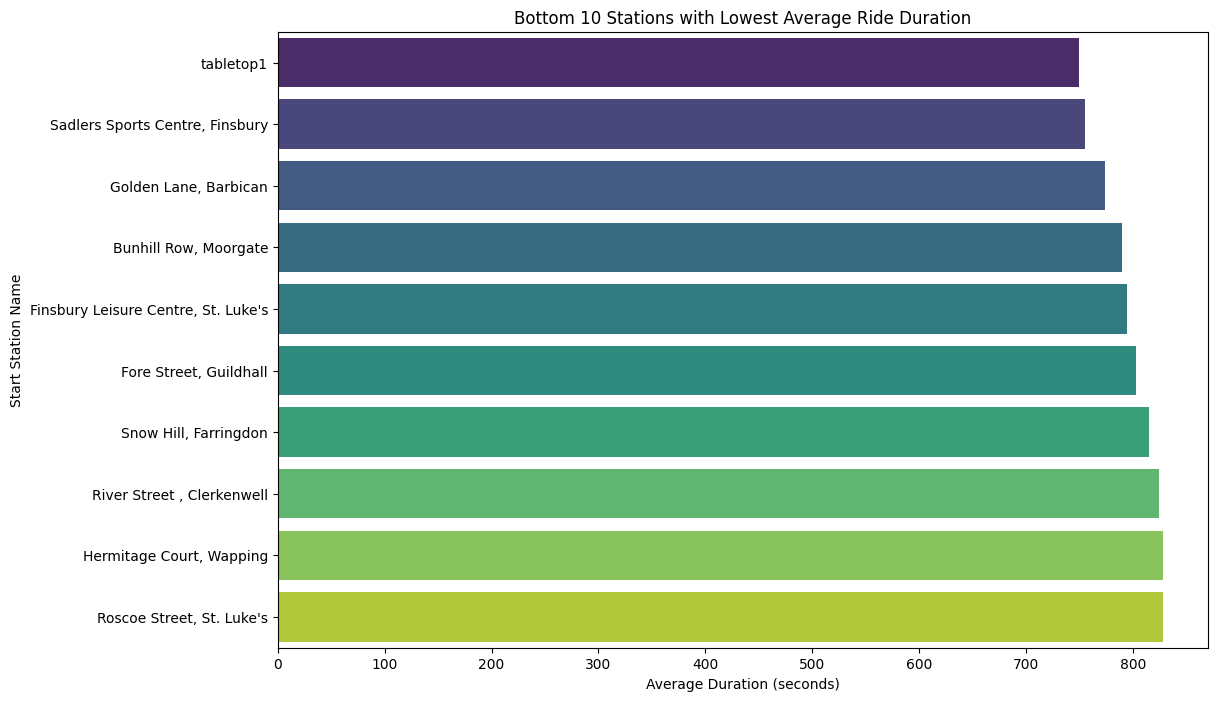

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=bottom_10_stations_df, x="Average_Duration", y="StartStation Name", palette="viridis")
plt.xlabel("Average Duration (seconds)")
plt.ylabel("Start Station Name")
plt.title("Bottom 10 Stations with Lowest Average Ride Duration")
plt.show()

Let us get the average duration for each month and compare

In [ ]:
from pyspark.sql import functions as F

# Extract month from the Start Date column
j_df_month = j_df.withColumn("StartMonth", F.month(F.to_date("Start Date", "dd/MM/yyyy HH:mm")))

# Group by month and calculate the average duration
monthly_avg_duration = j_df_month.groupBy("StartMonth").agg(F.avg("Duration").alias("Average Duration")).orderBy("StartMonth")


# Show the average duration for each month
monthly_avg_duration.show()



+----------+------------------+
|StartMonth|  Average Duration|
+----------+------------------+
|         1|1267.9849136679227|
|         2|1293.8808194609342|
|         3|1440.4395003557975|
|         4|1530.1822872056348|
|         5|1577.8602847558398|
|         6|1568.6224834397206|
|         7|1569.9078689512444|
|         8|1651.7460585208946|
|         9| 1413.699774683901|
|        10| 1354.910192715314|
|        11|1274.7543766125766|
|        12|1439.8962969978218|
+----------+------------------+



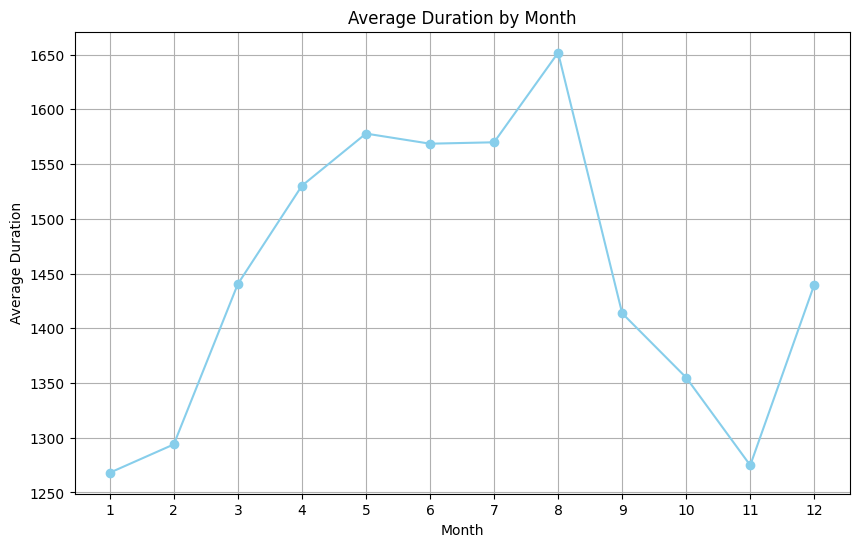

In [ ]:
import matplotlib.pyplot as plt

# Extracted data
months = [row['StartMonth'] for row in monthly_avg_duration.collect()]
avg_durations = [row['Average Duration'] for row in monthly_avg_duration.collect()]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(months, avg_durations, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Duration')
plt.title('Average Duration by Month')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a UDF to map months to seasons
def map_month_to_season(month):
    season_mapping = {
        1: "Winter",
        2: "Winter",
        3: "Spring",
        4: "Spring",
        5: "Spring",
        6: "Summer",
        7: "Summer",
        8: "Summer",
        9: "Autumn",
        10: "Autumn",
        11: "Autumn",
        12: "Winter"
    }
    return season_mapping.get(month)

# Register the UDF
map_month_to_season_udf = udf(map_month_to_season, StringType())

# Create a new column for season based on the mapped values
j_df_month_season = j_df_month.withColumn("Season", map_month_to_season_udf("StartMonth"))

# Show the DataFrame with the new Season column
j_df_month_season.show()



+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+----------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|StartMonth|Season|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+----------+------+
| 34263367|    1080|   9076|2014-06-24 00:57:00|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|         6|Summer|
| 34603487|     660|   6328|2014-07-03 11:51:00|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|         7|Summer|
| 34689078|     120|   2006|2014-07-05 15:09:00|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|         7|Summer|
| 34724273|    1260|   7904|2014-07-06 16:35:0

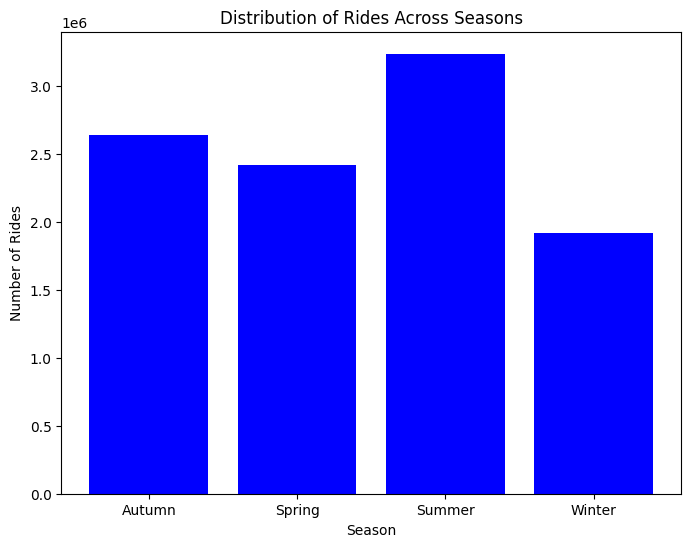

In [ ]:
import matplotlib.pyplot as plt

# Convert DataFrame to Pandas for plotting
season_counts = j_df_month_season.groupBy("Season").count().orderBy("Season").toPandas()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(season_counts["Season"], season_counts["count"], color="blue")
plt.xlabel("Season")
plt.ylabel("Number of Rides")
plt.title("Distribution of Rides Across Seasons")
plt.show()


In [ ]:
# Get unique StartStation Names
unique_stations = j_df.select("StartStation Name", "StartStation Id").distinct().orderBy("StartStation Name")
unique_stations.show(10, truncate=False)


+------------------------------------+---------------+
|StartStation Name                   |StartStation Id|
+------------------------------------+---------------+
|Abbey Orchard Street, Westminster   |108            |
|Abbotsbury Road, Holland Park       |559            |
|Aberdeen Place, St. John's Wood     |394            |
|Aberfeldy Street, Poplar            |554            |
|Abingdon Green, Great College Street|583            |
|Abingdon Villas, Kensington         |38             |
|Abyssinia Close, Clapham Junction   |776            |
|Ackroyd Drive, Bow                  |505            |
|Ada Street, Hackney Central         |718            |
|Addison Road, Holland Park          |606            |
+------------------------------------+---------------+
only showing top 10 rows



In [ ]:
# Filter the DataFrame to find all station names containing "Waterloo"
waterloo_stations = j_df.filter(col("StartStation Name").contains("Waterloo")).select("StartStation Name", "StartStation Id").distinct()
waterloo_stations.show(truncate=False)


+-------------------------------+---------------+
|StartStation Name              |StartStation Id|
+-------------------------------+---------------+
|Lambeth North Station, Waterloo|284            |
|Waterloo Station 1, Waterloo   |374            |
|Waterloo Station 3, Waterloo   |154            |
|King Edward Walk, Waterloo     |371            |
|Waterloo Place, St. James's    |160            |
|Waterloo Station 2, Waterloo   |361            |
|Waterloo Bridge, South Bank    |377            |
|Lower Marsh, Waterloo          |347            |
|Archbishop's Park, Waterloo    |641            |
|Baylis Road, Waterloo          |272            |
|Waterloo Roundabout, Waterloo  |173            |
+-------------------------------+---------------+



In [ ]:
# from above output, we now have station ID for Baylis Road, Waterloo station.
baylis_station_id = 272

In [ ]:
# Now let us filter the Dataset for rides starting from baylis station

baylis_rides = j_df.filter(col("StartStation Id") == baylis_station_id)

In [ ]:
baylis_rides.show(truncate = False)

+---------+--------+-------+----------------+-------------+-----------------------------------+----------------+---------------+---------------------+
|Rental Id|Duration|Bike Id|End Date        |EndStation Id|EndStation Name                    |Start Date      |StartStation Id|StartStation Name    |
+---------+--------+-------+----------------+-------------+-----------------------------------+----------------+---------------+---------------------+
|34335942 |600     |7213   |25/06/2014 18:59|199          |Great Tower Street, Monument       |25/06/2014 18:49|272            |Baylis Road, Waterloo|
|34292680 |540     |11506  |24/06/2014 18:12|199          |Great Tower Street, Monument       |24/06/2014 18:03|272            |Baylis Road, Waterloo|
|34251992 |600     |1845   |23/06/2014 17:58|199          |Great Tower Street, Monument       |23/06/2014 17:48|272            |Baylis Road, Waterloo|
|34618956 |720     |8070   |03/07/2014 17:59|199          |Great Tower Street, Monument       

In [ ]:
baylis_numRows = baylis_rides.count()
baylis_numRows

27210

In [ ]:
# Now let us filter the Dataset for rides starting from other station
other_rides = j_df.filter(col("StartStation Id") != baylis_station_id)

In [ ]:
avg_baylis_duration = baylis_rides.agg(avg("Duration")).collect()[0][0]
avg_other_duration = other_rides.agg(avg("Duration")).collect()[0][0]

print(f"Average duration of rides from Baylis Road, Waterloo: {avg_baylis_duration} seconds")
print(f"Average duration of rides from other stations: {avg_other_duration} seconds")


Average duration of rides from Baylis Road, Waterloo: 1044.6527012127895 seconds
Average duration of rides from other stations: 1471.7277966939612 seconds


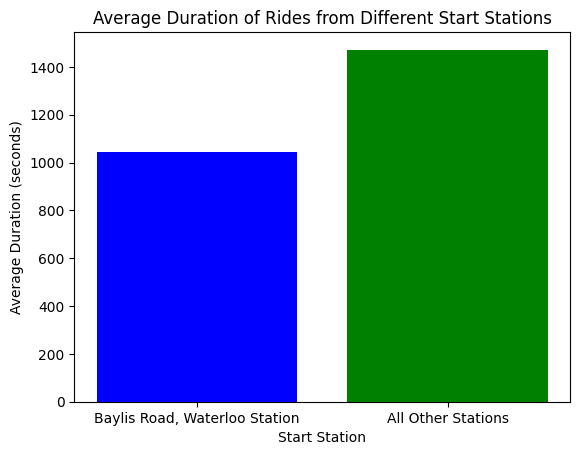

In [ ]:
import matplotlib.pyplot as plt

# Data for visualization
stations = ["Baylis Road, Waterloo Station", "All Other Stations"]
average_durations = [avg_baylis_duration, avg_other_duration]

# Create bar plot
plt.bar(stations, average_durations, color=['blue', 'green'])
plt.xlabel('Start Station')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration of Rides from Different Start Stations')
plt.show()


Statistical Testing

In [ ]:
# Extract duration values as a list
baylis_durations = baylis_rides.select("Duration").rdd.flatMap(lambda x: x).collect()


In [ ]:
# Extract duration values as a list
other_durations = other_rides.select("Duration").rdd.flatMap(lambda x: x).collect()


In [ ]:
import numpy as np

# Convert durations to numerical format
baylis_durations = np.array(baylis_durations, dtype=float)
other_durations = np.array(other_durations, dtype=float)

In [ ]:
from scipy import stats

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(baylis_durations, other_durations)

# Print results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check significance
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in ride durations.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in ride durations.")

T-Statistic: -5.429267942083923
P-Value: 5.658696083227228e-08
Reject null hypothesis: There is a significant difference in ride durations.
